## Loading Metrics from sources

In [1]:
from loadData import *
from model import *
import pandas as pd

# maybe you want to call a load on one of those datasets
# then call the load on the other
# and finally merge them?

# then do some analysis stuff, plots, etc.

# where do you want to run the bout analysis?

In [2]:
fitbit_df = loadFitbit().rename(columns={"Steps": "Steps_Fitbit"})
fitbit_df

Merging metrics: 100%|██████████| 3/3 [00:01<00:00,  2.26 Metric/s]


,DateTime,Calories,Subject,Steps_Fitbit,Intensities,METs
1321762,2014-10-21 00:00:00,0.9795,101,0,0,10
1322578,2014-10-21 00:01:00,1.1754,101,0,0,12
1323394,2014-10-21 00:02:00,0.9795,101,0,0,10
1324210,2014-10-21 00:03:00,0.9795,101,0,0,10
1325026,2014-10-21 00:04:00,0.9795,101,0,0,10
...,...,...,...,...,...,...
1318497,2014-11-23 23:53:00,0.8104,128,0,0,10
1319313,2014-11-23 23:54:00,0.8104,128,0,0,10
1320129,2014-11-23 23:55:00,0.8104,128,0,0,10
1320945,2014-11-23 23:56:00,0.8104,128,0,0,10


In [3]:
actigraph_df = loadActigraph().rename(columns={"Steps": "Steps_Actigraph"})
actigraph_df

Loading actigraph: 100%|██████████| 33/33 [00:00<00:00, 180.38 file/s]


,Steps_Actigraph,DateTime,Subject
226903,92,2014-10-20 13:00:00,101
226904,3,2014-10-20 13:01:00,101
226905,0,2014-10-20 13:02:00,101
226906,0,2014-10-20 13:03:00,101
226907,0,2014-10-20 13:04:00,101
...,...,...,...
189402,113,2014-11-07 11:48:00,128
189403,123,2014-11-07 11:49:00,128
189404,102,2014-11-07 11:50:00,128
189405,24,2014-11-07 11:51:00,128


In [4]:
merged_df = pd.merge(fitbit_df, actigraph_df, "left", ["Subject", "DateTime"])
merged_df

,DateTime,Calories,Subject,Steps_Fitbit,Intensities,METs,Steps_Actigraph
0,2014-10-21 00:00:00,0.9795,101,0,0,10,0.0
1,2014-10-21 00:01:00,1.1754,101,0,0,12,0.0
2,2014-10-21 00:02:00,0.9795,101,0,0,10,0.0
3,2014-10-21 00:03:00,0.9795,101,0,0,10,0.0
4,2014-10-21 00:04:00,0.9795,101,0,0,10,0.0
...,...,...,...,...,...,...,...
1818600,2014-11-23 23:53:00,0.8104,128,0,0,10,NaN
1818601,2014-11-23 23:54:00,0.8104,128,0,0,10,NaN
1818602,2014-11-23 23:55:00,0.8104,128,0,0,10,NaN
1818603,2014-11-23 23:56:00,0.8104,128,0,0,10,NaN


In [5]:
# Removing NA Steps
steps_df = merged_df.dropna(subset=["Steps_Fitbit","Steps_Actigraph"])
steps_df

,DateTime,Calories,Subject,Steps_Fitbit,Intensities,METs,Steps_Actigraph
0,2014-10-21 00:00:00,0.97950,101,0,0,10,0.0
1,2014-10-21 00:01:00,1.17540,101,0,0,12,0.0
2,2014-10-21 00:02:00,0.97950,101,0,0,10,0.0
3,2014-10-21 00:03:00,0.97950,101,0,0,10,0.0
4,2014-10-21 00:04:00,0.97950,101,0,0,10,0.0
...,...,...,...,...,...,...,...
1795627,2014-11-07 11:48:00,0.97248,128,0,0,12,113.0
1795628,2014-11-07 11:49:00,0.97248,128,0,0,12,123.0
1795629,2014-11-07 11:50:00,0.97248,128,0,0,12,102.0
1795630,2014-11-07 11:51:00,2.10704,128,11,1,26,24.0


## Training Model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [7]:
X = steps_df.drop(columns=["DateTime", "Subject", "Steps_Actigraph"])
X

,Calories,Steps_Fitbit,Intensities,METs
0,0.97950,0,0,10
1,1.17540,0,0,12
2,0.97950,0,0,10
3,0.97950,0,0,10
4,0.97950,0,0,10
...,...,...,...,...
1795627,0.97248,0,0,12
1795628,0.97248,0,0,12
1795629,0.97248,0,0,12
1795630,2.10704,11,1,26


In [8]:
y = steps_df["Steps_Actigraph"]
y

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
           ...  
1795627    113.0
1795628    123.0
1795629    102.0
1795630     24.0
1795631     12.0
Name: Steps_Actigraph, Length: 778015, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Linear Regression

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
y_linear_pred = model.predict(X_test)
linear_metrics = get_metrics(y_test, y_linear_pred)
linear_metrics

{'r2': 0.4968792905872855,
 'rmse': np.float64(15.985146638702512),
 'mae': 6.965172399371337}

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_metrics = get_metrics(y_test, y_pred_rf)

## Comparisons

In [13]:
compare_models(linear_metrics, rf_metrics)


Baseline: R2=0.4969, RMSE=15.99, MAE=6.97
New: R2=0.5432, RMSE=15.23, MAE=6.54
Change: R2=+0.0463, RMSE=-0.75, MAE=-0.42


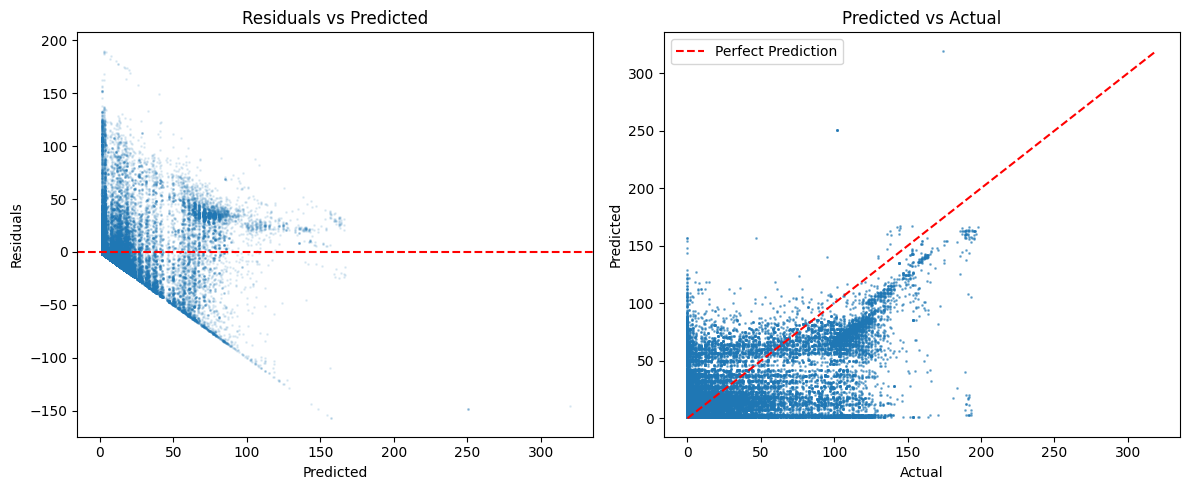

In [16]:
_ = plot_residuals(y_test, y_linear_pred)

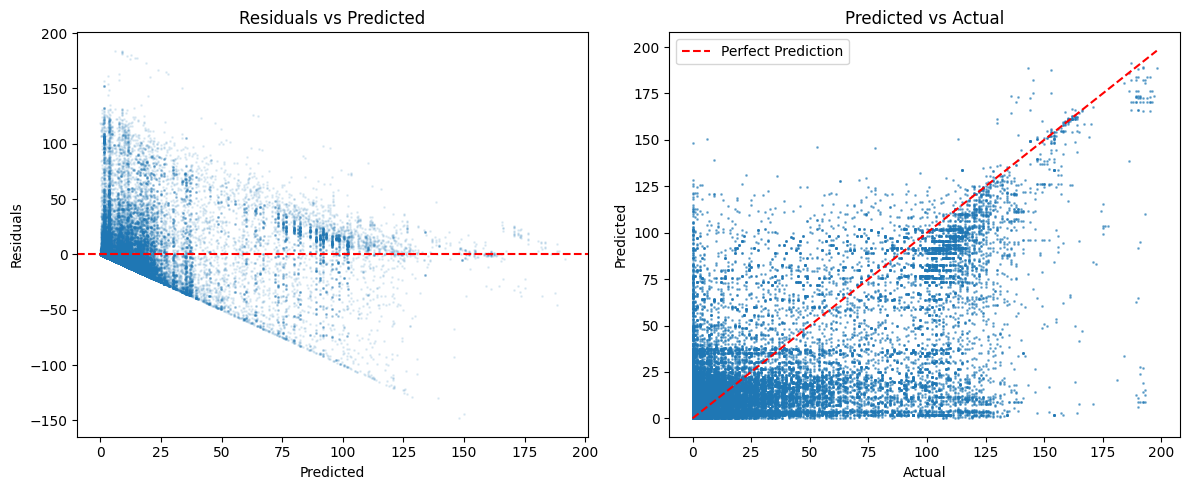

In [14]:
_ = plot_residuals(y_test, y_pred_rf)